In [ ]:
### PHASE 1: DATA UNDERSTANDING AND PREPERATION

# Install and import libraries

import os
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# Download dataset with kagglehub

import kagglehub

# Download latest version of the dataset

path = kagglehub.dataset_download(
    "atharvasoundankar/gen-ai-misinformation-detection-datase-20242025"
)

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'gen-ai-misinformation-detection-datase-20242025' dataset.
Path to dataset files: /kaggle/input/gen-ai-misinformation-detection-datase-20242025


In [ ]:
# List contents of download directory

import os

print("Files in dataset download folder:")
for each in os.listdir(path):
    print("-", each)

Files in dataset download folder:
- generative_ai_misinformation_dataset.csv


In [ ]:
# Load main CSV into pandas

CSV_FILE = "generative_ai_misinformation_dataset.csv"

csv_path = os.path.join(path, CSV_FILE)
print("Loading:", csv_path)

df = pd.read_csv(csv_path)
df.head()


Loading: /kaggle/input/gen-ai-misinformation-detection-datase-20242025/generative_ai_misinformation_dataset.csv


,id,post_id,platform,timestamp,date,time,month,weekday,country,city,...,sentiment_score,toxicity_score,model_signature,detected_synthetic_score,embedding_sim_to_facts,factcheck_verdict,external_factchecks_count,source_domain_reliability,engagement,is_misinformation
0,1,P0001,Reddit,2024-03-06 10:01:00,2024-03-06,10:01:00,March,Wednesday,USA,New York,...,-0.223,0.271,GPT-like,0.829,0.357,TRUE,4,0.543,3899,1
1,2,P0002,Reddit,2025-08-07 18:30:00,2025-08-07,18:30:00,August,Thursday,Germany,Berlin,...,-0.718,0.802,GPT-like,0.075,0.987,FALSE,3,0.199,7651,0
2,3,P0003,Telegram,2024-12-13 03:15:00,2024-12-13,03:15:00,December,Friday,USA,New York,...,-0.989,0.815,GPT-like,0.707,0.729,PARTLY,0,0.074,7260,0
3,4,P0004,Twitter,2024-04-05 07:10:00,2024-04-05,07:10:00,April,Friday,USA,Chicago,...,-0.283,0.116,human,0.863,0.623,FALSE,2,0.064,7454,1
4,5,P0005,Telegram,2024-06-07 06:18:00,2024-06-07,06:18:00,June,Friday,Germany,Hamburg,...,-0.378,0.325,GPT-like,0.730,0.638,PARTLY,0,0.472,8320,0


In [ ]:
# Checking data structure

## Shape, column names, preview

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
df.head()

## Data types and missing values

df.info()
df.isna().sum().sort_values(ascending=False)

Shape: (500, 31)

Columns: ['id', 'post_id', 'platform', 'timestamp', 'date', 'time', 'month', 'weekday', 'country', 'city', 'timezone', 'author_id', 'author_followers', 'author_verified', 'text', 'text_length', 'token_count', 'readability_score', 'num_urls', 'num_mentions', 'num_hashtags', 'sentiment_score', 'toxicity_score', 'model_signature', 'detected_synthetic_score', 'embedding_sim_to_facts', 'factcheck_verdict', 'external_factchecks_count', 'source_domain_reliability', 'engagement', 'is_misinformation']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         500 non-null    int64  
 1   post_id                    500 non-null    object 
 2   platform                   500 non-null    object 
 3   timestamp                  500 non-null    object 
 4   date                       500 non-nul

,0
id,0
post_id,0
platform,0
timestamp,0
date,0
time,0
month,0
weekday,0
country,0
city,0


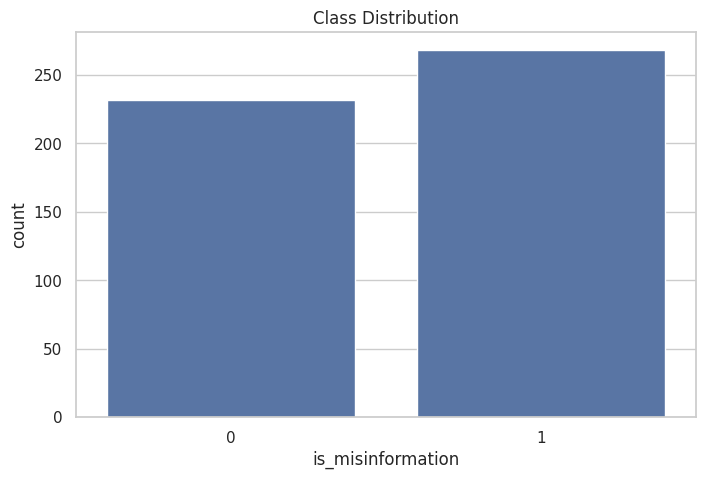

In [ ]:
# Inspect target variable (is_misinformation) distribution

TARGET = "is_misinformation"

if TARGET not in df.columns:
    raise KeyError(f"Target column '{TARGET}' not found. Check df.columns.")

## Distribution

df[TARGET].value_counts()

## Percentage

df[TARGET].value_counts(normalize=True)

## Plot

sns.countplot(x=TARGET, data=df)
plt.title("Class Distribution")
plt.show()

## NOTE - from shan: consider reporting Precision-Recall AUC if the dataset has class imbalance


In [ ]:
# Identify numeric, categorical, text, and ID/time columns

## Define target + group ID/time/text columns

# 1) Target column for classification

TARGET = "is_misinformation"

# 2) Columns that are identifiers (probably not used as features)

ID_COLS = ["id", "post_id", "author_id"]

# 3) Columns that represent time/date information

TIME_COLS = ["timestamp", "date", "time", "month", "weekday"]

  # Might later include features for "hour of day" or "day of week"

# 4) Main free-text column

TEXT_COLS = ["text"]

## Using dtypes to get numeric vs. "object"

  # We know from df.info():
  ## float64 + int64 = numeric
  ## object = string-like (IDs, text, category labels, etc.)

import numpy as np

# All numeric columns (int64, float64)

numeric_all = df.select_dtypes(include=[np.number]).columns.tolist()

# All object / category columns

categorical_all = df.select_dtypes(include=["object", "category"]).columns.tolist()

print("All numeric columns:", numeric_all)
print("\nAll object-like columns:", categorical_all)


All numeric columns: ['id', 'author_followers', 'author_verified', 'text_length', 'token_count', 'readability_score', 'num_urls', 'num_mentions', 'num_hashtags', 'sentiment_score', 'toxicity_score', 'detected_synthetic_score', 'embedding_sim_to_facts', 'external_factchecks_count', 'source_domain_reliability', 'engagement', 'is_misinformation']

All object-like columns: ['post_id', 'platform', 'timestamp', 'date', 'time', 'month', 'weekday', 'country', 'city', 'timezone', 'author_id', 'text', 'model_signature', 'factcheck_verdict']


In [ ]:
# Building feature groups

## 1) Numeric feature columns:

  # Start from numeric_all
  # Remove target and numeric IDs

numeric_features = [
    col for col in numeric_all
    if col not in [TARGET] + ["id"]  # we keep author_verified as numeric (0/1)
]

print("Numeric feature columns:")
print(numeric_features)

## 2) Text feature columns (we already defined TEXT_COLS)

text_features = [col for col in TEXT_COLS if col in df.columns]

print("\nText feature columns:")
print(text_features)

## 3) Categorical feature columns:

  # Start from all object-like columns
  # Remove text column(s)
  # Remove obvious ID/time-like columns

categorical_features = [
    col for col in categorical_all
    if col not in TEXT_COLS + ID_COLS + TIME_COLS
]

print("\nCategorical feature columns:")
print(categorical_features)

## Inspecting categorical features

for col in categorical_features:
    print(f"\nColumn: {col}")
    print(df[col].value_counts().head(10))


Numeric feature columns:
['author_followers', 'author_verified', 'text_length', 'token_count', 'readability_score', 'num_urls', 'num_mentions', 'num_hashtags', 'sentiment_score', 'toxicity_score', 'detected_synthetic_score', 'embedding_sim_to_facts', 'external_factchecks_count', 'source_domain_reliability', 'engagement']

Text feature columns:
['text']

Categorical feature columns:
['platform', 'country', 'city', 'timezone', 'model_signature', 'factcheck_verdict']

Column: platform
platform
Twitter     129
Facebook    126
Telegram    124
Reddit      121
Name: count, dtype: int64

Column: country
country
Germany    113
USA        105
UK         102
Brazil      94
India       86
Name: count, dtype: int64

Column: city
city
Los Angeles    51
Munich         40
Hamburg        38
Sao Paulo      38
Manchester     36
Berlin         35
Birmingham     34
Delhi          33
Brasilia       33
London         32
Name: count, dtype: int64

Column: timezone
timezone
CET    113
EST    105
GMT    102
BRT

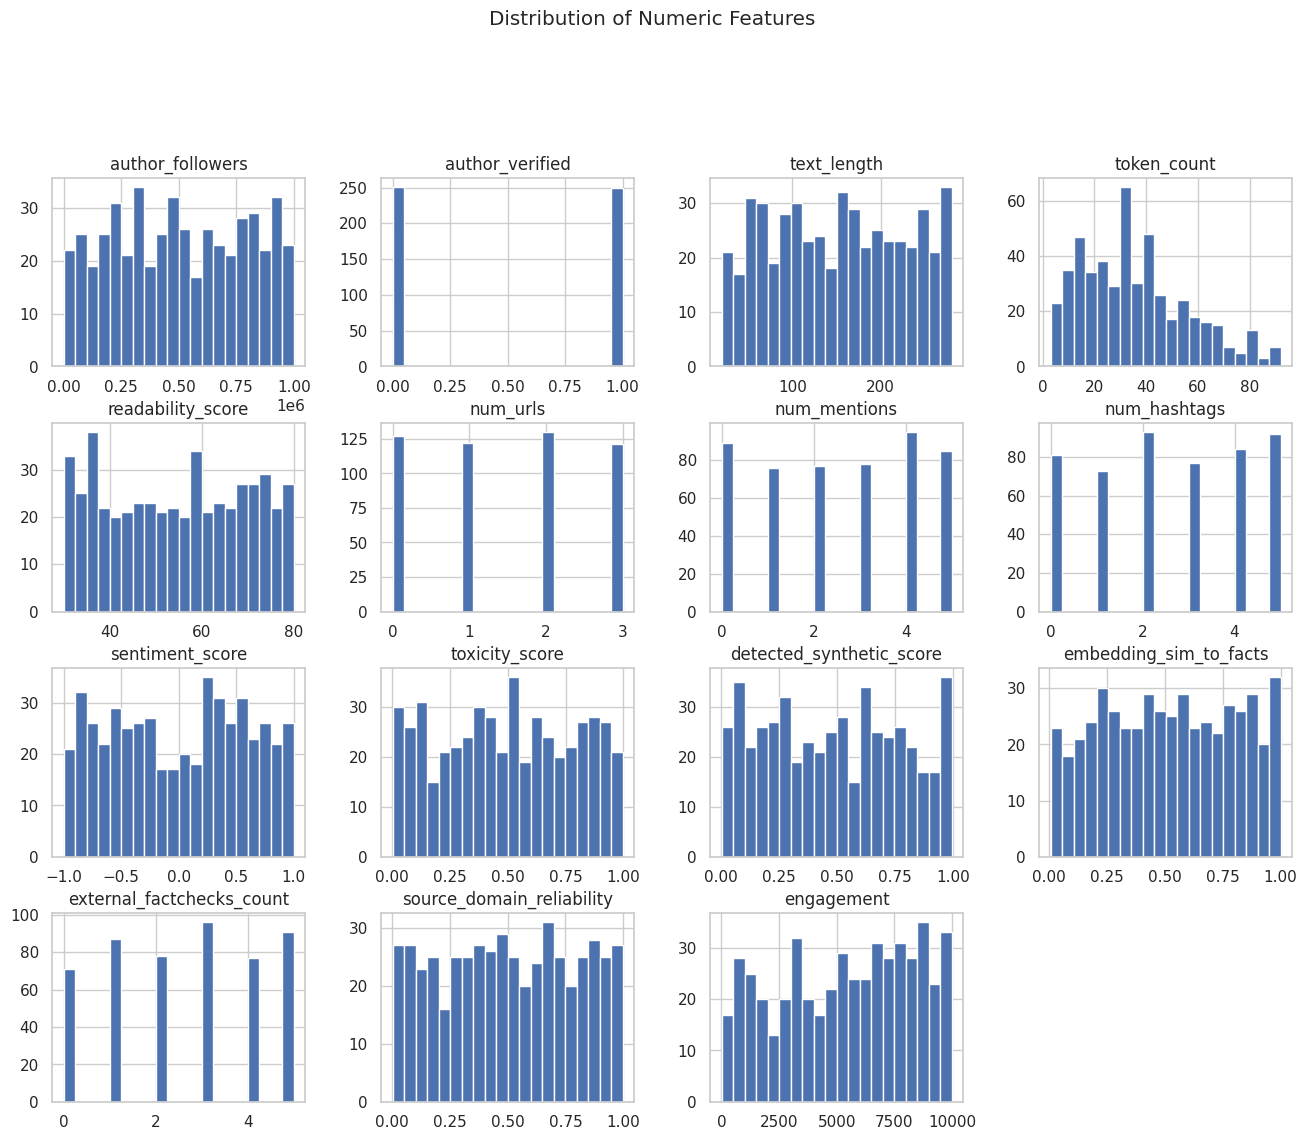

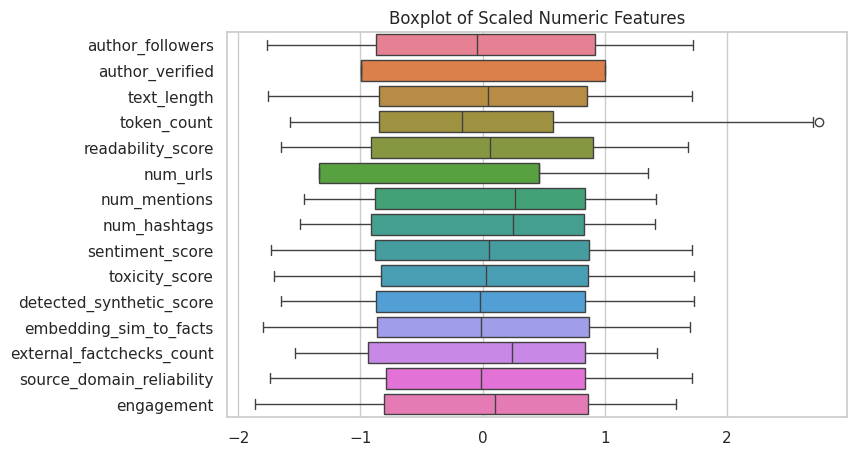

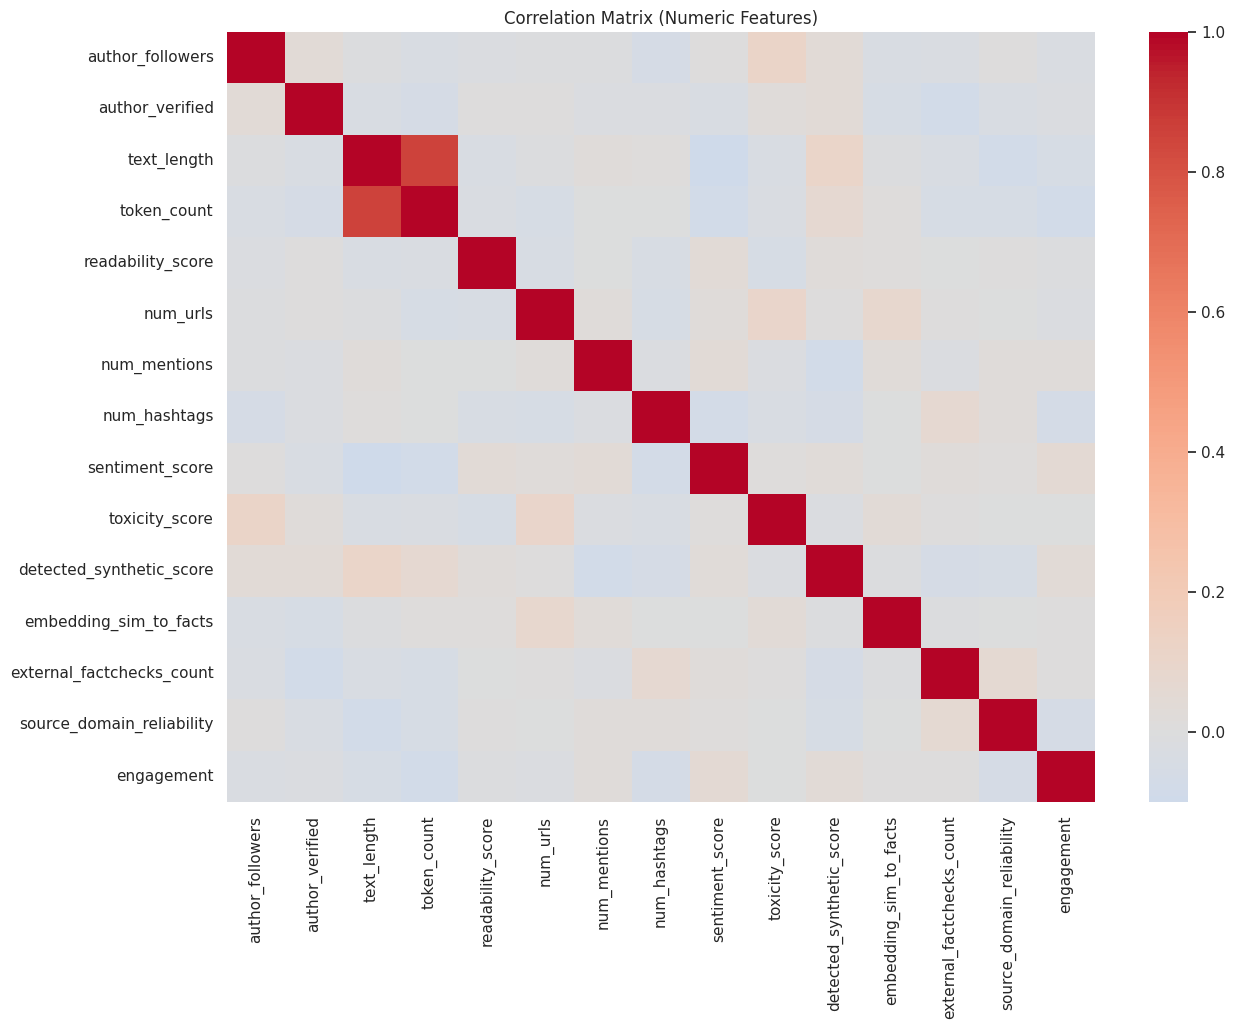


===== platform =====
platform
Twitter     129
Facebook    126
Telegram    124
Reddit      121
Name: count, dtype: int64

===== country =====
country
Germany    113
USA        105
UK         102
Brazil      94
India       86
Name: count, dtype: int64

===== city =====
city
Los Angeles       51
Munich            40
Hamburg           38
Sao Paulo         38
Manchester        36
Berlin            35
Birmingham        34
Delhi             33
Brasilia          33
London            32
New York          30
Mumbai            29
Chicago           24
Bangalore         24
Rio de Janeiro    23
Name: count, dtype: int64

===== timezone =====
timezone
CET    113
EST    105
GMT    102
BRT     94
IST     86
Name: count, dtype: int64

===== model_signature =====
model_signature
human       174
unknown     169
GPT-like    157
Name: count, dtype: int64

===== factcheck_verdict =====
factcheck_verdict
PARTLY        144
TRUE          121
FALSE         120
UNVERIFIED    115
Name: count, dtype: int64


In [ ]:
# Summary Statistics (EDA)

## Summary table for numeric features

numeric_summary = df[numeric_features].describe().T
numeric_summary

  # Looking for:
    ## Large ranges = possible outliers
    ## Highly skewed variables (such as engagements, followers)
    ## Variables with near-zero variance (uninformative)

## Histograms for all numeric features

df[numeric_features].hist(bins=20, figsize=(16, 12))
plt.suptitle("Distribution of Numeric Features", y=1.02)
plt.show()

  # Reveals distribution shape (normal, skewed, multi-modal)

## Boxplot for outlier detection

  # Standardizing the scale of all boxplots, making comparisons more interpretable

from sklearn.preprocessing import StandardScaler

scaled = StandardScaler().fit_transform(df[numeric_features])
scaled_df = pd.DataFrame(scaled, columns=numeric_features)

sns.boxplot(data=scaled_df, orient="h")
plt.title("Boxplot of Scaled Numeric Features")
plt.show()

  # Reveals extreme engagement/score values
  # Extreme outliers can heavily influence our logistc regression and tree splits.
  # May later need to trim or winsorsize

## Correlation matrix (numeric-only)

plt.figure(figsize=(14, 10))
corr = df[numeric_features].corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

  # Visualizing relationships between features (referenced in feedback)

## Summary of categorical variables

  # Computing frequency tables for each category

for col in categorical_features:
    print(f"\n===== {col} =====")
    print(df[col].value_counts())

  # Helping with:
    ## Discovering rare categories (may need grouping)
    ## Verifying disribution across platforms, countries, factcheck verdicts
    ## Identifying categorical imbalance





In [ ]:
### PHASE 2: FEATURE ENGINGEERING & PREPROCESSING

# Building the preprocessing pipeline

## Import transformers

from sklearn.preprocessing import StandardScaler, OneHotEncoder
  # StandardScaler: makes numeric features comparable (mean 0, std 1)
  # OneHotEncoder: turns categories into 0/1 columns

from sklearn.feature_extraction.text import TfidfVectorizer
  # TfidfVectorizer: converts text into weighted word features

from sklearn.compose import ColumnTransformer
  # ColumnTransformer: lets us apply all three at once for reproducibility

## Defining per-type transformers

# Numeric: standardize all continuous / count features

numeric_transformer = StandardScaler()
  # Helps linear models (like log. regression and SVM) and makes optimization more stable

# Categorical: one-hot encode, ignore unseen categories at test time

categorical_transformer = OneHotEncoder(handle_unknown="ignore")
  # Preserves all category information without imposing artifical order

# Text: TF–IDF on the main post text
# max_features limits vocab size (important with only 500 rows)

text_transformer = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 2),       # unigrams + bigrams
    stop_words="english"
)
  # Gives higher weight to words/phrases that are informative for distinguishing misinformation vs. not
  # Down-weights common words

## Building the combined preprocessor
  # Plug the features list into a ColumnTransformer

# Use the actual text column name from text_features list
TEXT_COL = "text"

preprocessor = ColumnTransformer(
    transformers=[
        ("num",  numeric_transformer,      numeric_features),
        ("cat",  categorical_transformer,  categorical_features),
        ("text", text_transformer,         TEXT_COL),
    ],
    remainder="drop"   # drop id/time columns and anything not specified
)

## Sanity check for transformed shape
  # Verifying the preprocessor runs and shows how many features we end up with

# Build X matrix only from columns we intend to use
X = df[numeric_features + categorical_features + [TEXT_COL]]

# Fit the preprocessor on the full data (for inspection; in practice we'll do this inside a pipeline on train only)
preprocessor.fit(X)

X_transformed = preprocessor.transform(X)

print("Original shape:", X.shape)
print("Transformed shape:", X_transformed.shape)



Original shape: (500, 22)
Transformed shape: (500, 1051)


In [ ]:
### Phase 3: MODELING

# (1): Train/Test Split

from sklearn.model_selection import train_test_split

TARGET = "is_misinformation"
TEXT_COL = "text"

# X = all features we intend to use
X = df[numeric_features + categorical_features + [TEXT_COL]]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

  # Stratification: keeps fake/real proportions similar in both sets, making evaluation fair
  # Keeping the splits simple, we can layer cross-validation later


Train shape: (350, 22)
Test shape: (150, 22)


(is_misinformation
 1    0.537143
 0    0.462857
 Name: proportion, dtype: float64,
 is_misinformation
 1    0.533333
 0    0.466667
 Name: proportion, dtype: float64)

In [ ]:
# (2): Logistic Regression Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

log_reg_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", LogisticRegression(
            max_iter=1000,
            # class_weight="balanced"  # uncomment if classes are imbalanced
        ))
    ]
)

log_reg_pipeline

  # Notes on strucutre
    # Keeps preprocessing and the model tied together to avoid data leakage
    # When we do CV or hyperparameter tuning later, the pipelines ensure preprocessing is refit only on training folds


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['author_followers',
                                                   'author_verified',
                                                   'text_length', 'token_count',
                                                   'readability_score',
                                                   'num_urls', 'num_mentions',
                                                   'num_hashtags',
                                                   'sentiment_score',
                                                   'toxicity_score',
                                                   'detected_synthetic_score',
                                                   'embedding_sim_to_facts',
                                                   'external_factchecks_count',
                                                   'source_domain_reliability',
                                                   'engagement']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['platform', 'country',
                                                   'city', 'timezone',
                                                   'model_signature',
                                                   'factcheck_verdict']),
                                                 ('text',
                                                  TfidfVectorizer(max_features=1000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'text')])),
                ('model', LogisticRegression(max_iter=1000))])

In [ ]:
# (3): Fitting the baseline model

log_reg_pipeline.fit(X_train, y_train)

  # During .fit():
    # preprocess:
      # Learns scaling parameters (mean/std) on numeric features
      # Learns one-hot categories
      # Learns TF-IDF vocabulary
    # model:
      # Learns logistic regression coefficients in that transformed space

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['author_followers',
                                                   'author_verified',
                                                   'text_length', 'token_count',
                                                   'readability_score',
                                                   'num_urls', 'num_mentions',
                                                   'num_hashtags',
                                                   'sentiment_score',
                                                   'toxicity_score',
                                                   'detected_synthetic_score',
                                                   'embedding_sim_to_facts',
                                                   'external_factchecks_count',
                                                   'source_domain_reliability',
                                                   'engagement']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['platform', 'country',
                                                   'city', 'timezone',
                                                   'model_signature',
                                                   'factcheck_verdict']),
                                                 ('text',
                                                  TfidfVectorizer(max_features=1000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'text')])),
                ('model', LogisticRegression(max_iter=1000))])

In [ ]:
# (4): Evaluate on Test Set
  # Compute: accuracy, ROC-AUC, classificaiton report (precision, recall, F1)

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Class predictions
y_pred = log_reg_pipeline.predict(X_test)

# Predicted probabilities for the positive class
y_prob = log_reg_pipeline.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"Logistic Regression - Test Accuracy: {acc:.3f}")
print(f"Logistic Regression - Test ROC-AUC: {auc:.3f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

  # Readability
    # Accuracy: overall fraction of correct predictions.
    # ROC-AUC: how well the model ranks true positives above true negatives.
    # Classification report: precision/recall/F1 per class; helpful if the classes are imbalanced

Logistic Regression - Test Accuracy: 0.527
Logistic Regression - Test ROC-AUC: 0.493

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.40      0.44        70
           1       0.55      0.64      0.59        80

    accuracy                           0.53       150
   macro avg       0.52      0.52      0.52       150
weighted avg       0.52      0.53      0.52       150



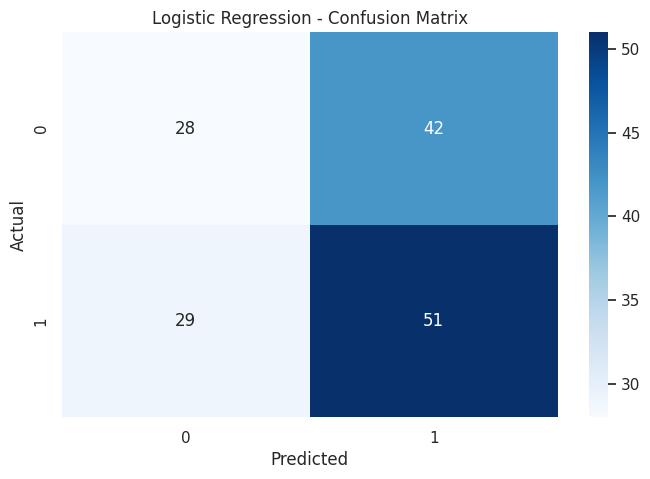

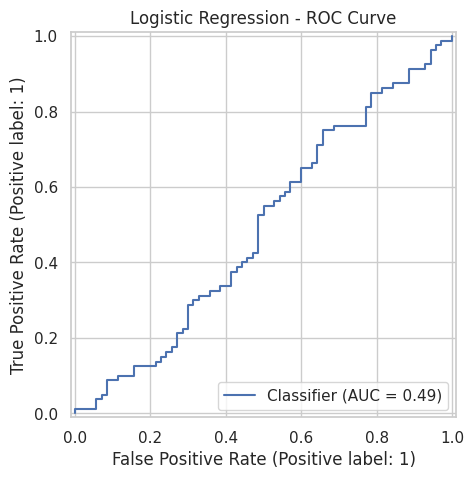

In [ ]:
# (5): Confusion Matrix & ROC Curve

# Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

  # Tells us how many fake posts were missed vs correctly caught

# ROC Curve

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("Logistic Regression - ROC Curve")
plt.show()

  # Shows trade-off between true positive rate and fale positive rate at varying thresholds


In [ ]:
### PHASE 4: BUILDING ADDITIONAL MODELS & COMPARING THEM

Decision Tree - Test Accuracy: 0.487
Decision Tree - Test ROC-AUC: 0.506

Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.41      0.43        70
           1       0.52      0.55      0.53        80

    accuracy                           0.49       150
   macro avg       0.48      0.48      0.48       150
weighted avg       0.48      0.49      0.48       150



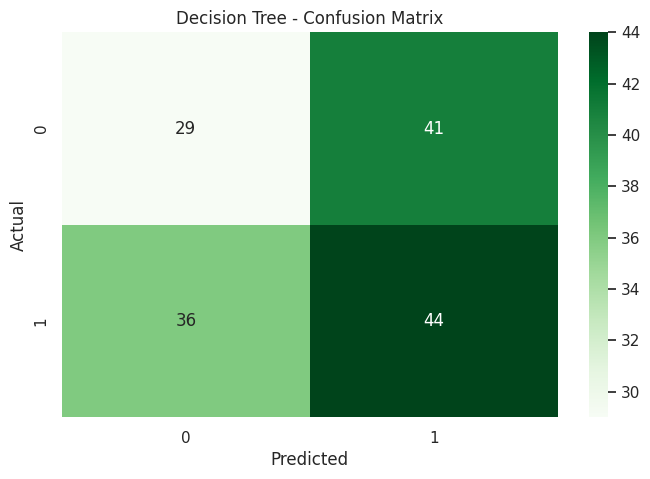

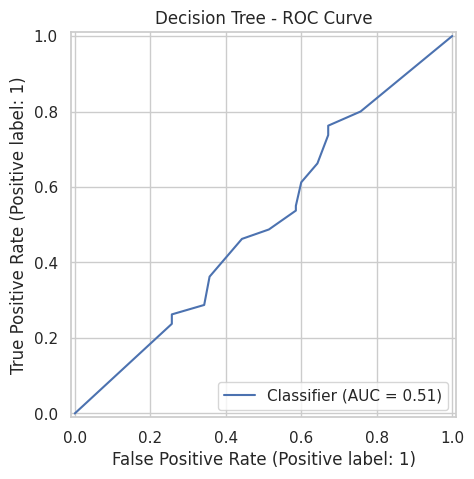

In [ ]:
# Decision tree pipeline

## Import and define model

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

# Decision tree with modest depth to reduce overfitting a bit
dt_model = DecisionTreeClassifier(
    max_depth=10,      # can tune this later
    min_samples_leaf=5,
    random_state=42
)

dt_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", dt_model)
    ]
)

dt_pipeline

## Fit the decision tree

dt_pipeline.fit(X_train, y_train)

## Evaluate on the test set

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Predictions
y_pred_dt = dt_pipeline.predict(X_test)
y_prob_dt = dt_pipeline.predict_proba(X_test)[:, 1]

acc_dt = accuracy_score(y_test, y_pred_dt)
auc_dt = roc_auc_score(y_test, y_prob_dt)

print(f"Decision Tree - Test Accuracy: {acc_dt:.3f}")
print(f"Decision Tree - Test ROC-AUC: {auc_dt:.3f}\n")

print("Decision Tree - Classification Report:")
print(classification_report(y_test, y_pred_dt))

## Confusion matrix and ROC curve

  # Decision Tree

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_dt = confusion_matrix(y_test, y_pred_dt)

sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree - Confusion Matrix")
plt.show()

  # ROC Curve

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_prob_dt)
plt.title("Decision Tree - ROC Curve")
plt.show()




Random Forest - Test Accuracy: 0.540
Random Forest - Test ROC-AUC: 0.520

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.01      0.03        70
           1       0.54      1.00      0.70        80

    accuracy                           0.54       150
   macro avg       0.77      0.51      0.36       150
weighted avg       0.75      0.54      0.39       150



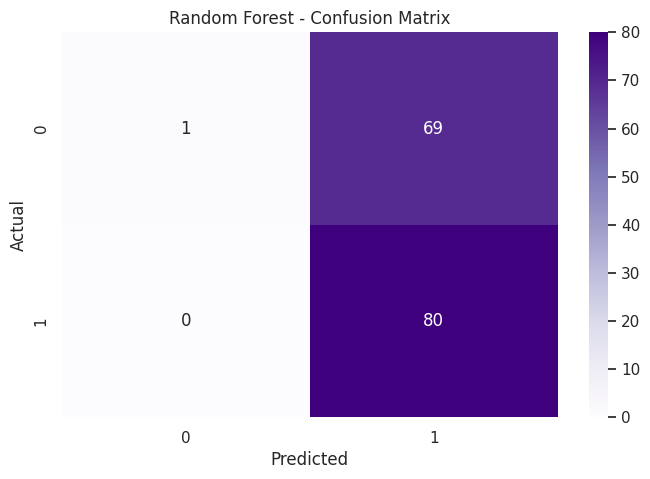

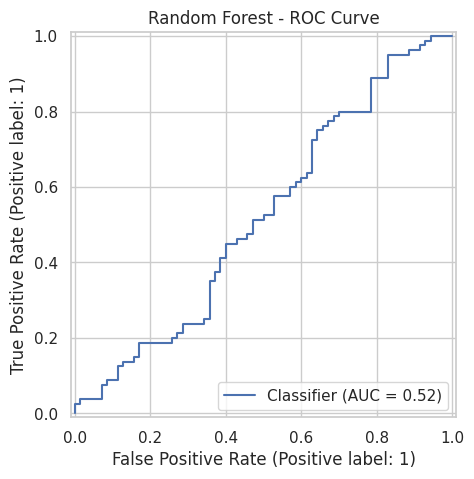

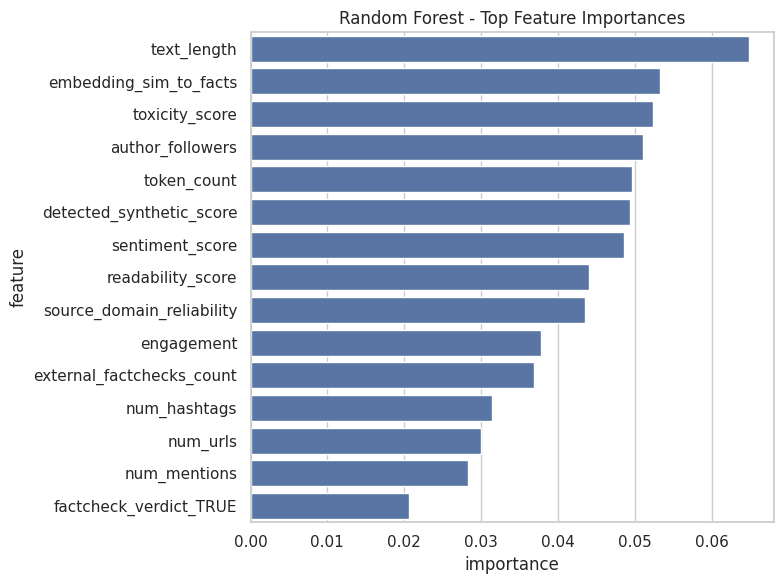

In [ ]:
# Random forest pipeline

## Define the random forest pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf_model = RandomForestClassifier(
    n_estimators=300,      # number of trees
    max_depth=None,       # let trees grow deep; can tune later
    min_samples_leaf=5,   # small regularization to reduce overfitting
    n_jobs=-1,            # use all cores
    random_state=42
)

rf_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", rf_model)
    ]
)

rf_pipeline

## Fit the random forest

rf_pipeline.fit(X_train, y_train)

## Evaluate on test set

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]

acc_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)

print(f"Random Forest - Test Accuracy: {acc_rf:.3f}")
print(f"Random Forest - Test ROC-AUC: {auc_rf:.3f}\n")

print("Random Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))

## Confusion matrix and ROC curve

  # Confusion matric

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_rf = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Purples")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest - Confusion Matrix")
plt.show()

  # ROC Curve

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_prob_rf)
plt.title("Random Forest - ROC Curve")
plt.show()

# Feature importances from the random forest

## Build aligned feature name list

import numpy as np
import pandas as pd

# Grab fitted preprocessor and model from the pipeline
fitted_preprocessor = rf_pipeline.named_steps["preprocess"]
fitted_rf = rf_pipeline.named_steps["model"]

# 1) Numeric feature names (unchanged)
num_names = numeric_features

# 2) Categorical feature names (expanded by one-hot)
cat_encoder = fitted_preprocessor.named_transformers_["cat"]
cat_names = cat_encoder.get_feature_names_out(categorical_features)

# 3) Text feature names from TF-IDF
text_vectorizer = fitted_preprocessor.named_transformers_["text"]
text_names = text_vectorizer.get_feature_names_out()

# Concatenate all
all_feature_names = np.concatenate([num_names, cat_names, text_names])

len(all_feature_names), fitted_rf.feature_importances_.shape

## Get top-k most important features

importances = fitted_rf.feature_importances_

feat_imp = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
})

feat_imp_sorted = feat_imp.sort_values("importance", ascending=False)

# Show top 20
feat_imp_sorted.head(20)

  # ANSWERS: which features does a strong nonlinear model rely on?

## Plot top importances

top_k = 15
top_feats = feat_imp_sorted.head(top_k)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=top_feats,
    x="importance",
    y="feature"
)
plt.title("Random Forest - Top Feature Importances")
plt.tight_layout()
plt.show()


XGBoost - Test Accuracy: 0.547
XGBoost - Test ROC-AUC: 0.539

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.43      0.47        70
           1       0.57      0.65      0.60        80

    accuracy                           0.55       150
   macro avg       0.54      0.54      0.54       150
weighted avg       0.54      0.55      0.54       150



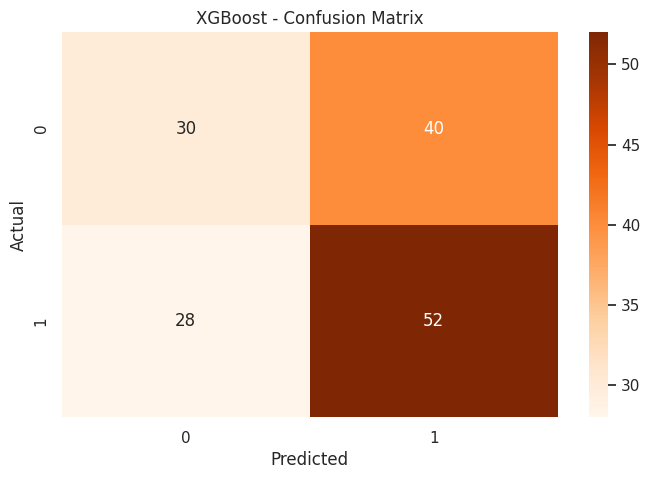

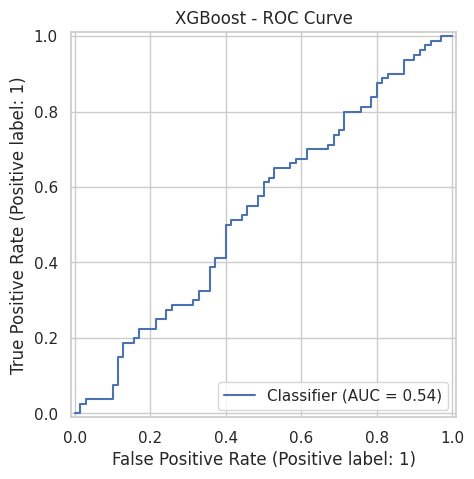

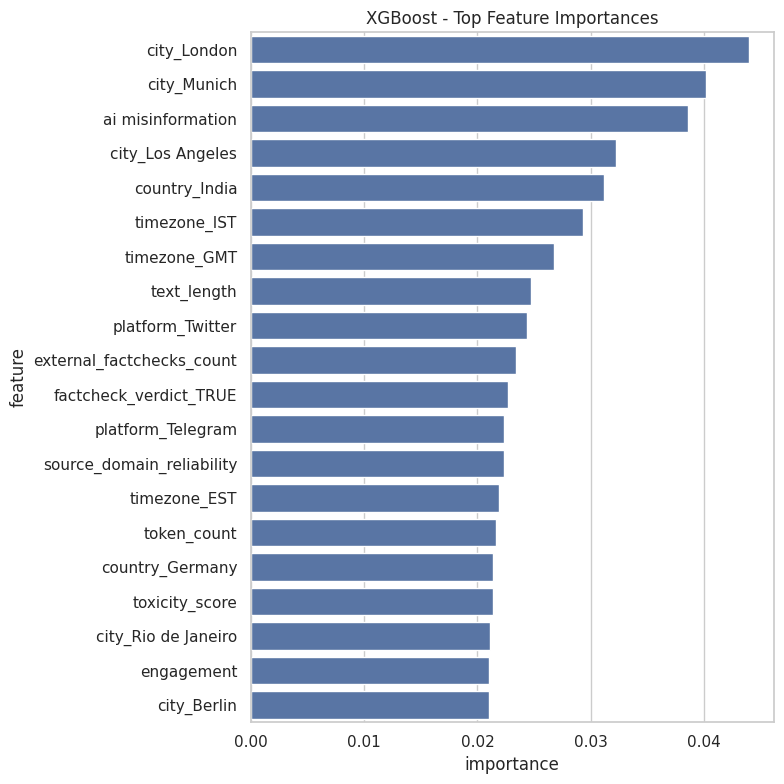

In [ ]:
# Gradient Boost

## Install and import XGBoost

!pip install xgboost

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

## Build XGBoost Pipeline

xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    n_jobs=-1,
    random_state=42
)

xgb_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", xgb_model)
    ]
)

xgb_pipeline

## Fit the XGBoost pipeline

xgb_pipeline.fit(X_train, y_train)

## Evalaute on test set

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

y_pred_xgb = xgb_pipeline.predict(X_test)
y_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

acc_xgb = accuracy_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)

print(f"XGBoost - Test Accuracy: {acc_xgb:.3f}")
print(f"XGBoost - Test ROC-AUC: {auc_xgb:.3f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

## Confusion matrix and ROC curve

  # Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_xgb = confusion_matrix(y_test, y_pred_xgb)

sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Oranges")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost - Confusion Matrix")
plt.show()

  # ROC Curve

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_prob_xgb)
plt.title("XGBoost - ROC Curve")
plt.show()

# Feature Importances

import numpy as np
import pandas as pd

fitted_preprocessor = xgb_pipeline.named_steps["preprocess"]
fitted_xgb = xgb_pipeline.named_steps["model"]


  # Extract top features

xgb_importances = fitted_xgb.feature_importances_

feat_imp_xgb = pd.DataFrame({
    "feature": all_feature_names,
    "importance": xgb_importances
})

feat_imp_xgb_sorted = feat_imp_xgb.sort_values("importance", ascending=False)

feat_imp_xgb_sorted.head(20)

  # Plot top features

top_k = 20
top_feats_xgb = feat_imp_xgb_sorted.head(top_k)

plt.figure(figsize=(8, 8))
sns.barplot(data=top_feats_xgb, x="importance", y="feature")
plt.title("XGBoost - Top Feature Importances")
plt.tight_layout()
plt.show()






SVM (linear) - Test Accuracy: 0.547
SVM (linear) - Test ROC-AUC: 0.511

SVM (linear) - Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.27      0.36        70
           1       0.55      0.79      0.65        80

    accuracy                           0.55       150
   macro avg       0.54      0.53      0.50       150
weighted avg       0.54      0.55      0.51       150



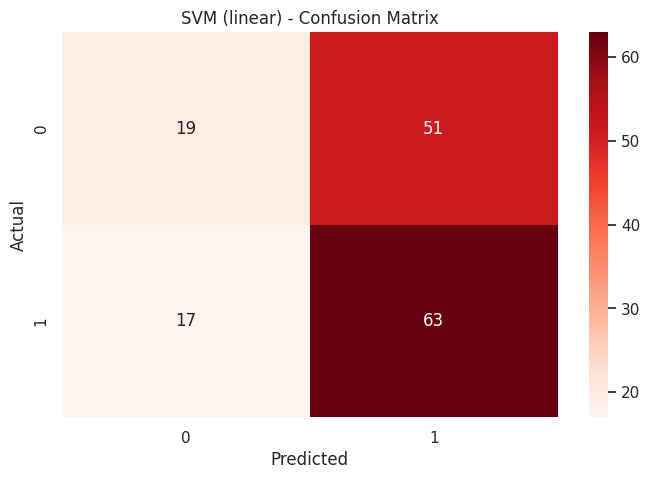

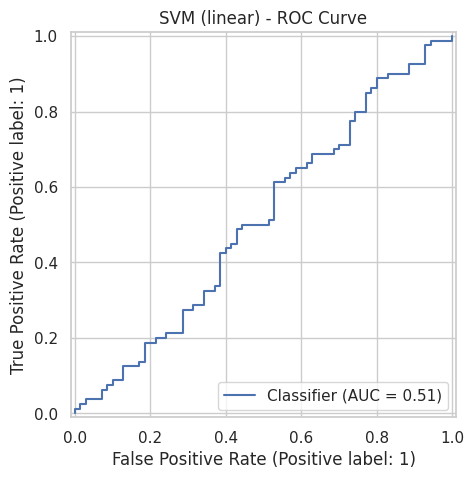

In [ ]:
# SVM

## Define the SVM pipeline

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

svm_model = SVC(
    kernel="linear",      # linear SVM works best with high-dim sparse data
    C=1.0,                # regularization strength (can tune later)
    probability=True,     # enables predict_proba for ROC-AUC
    random_state=42
)

svm_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", svm_model)
    ]
)

svm_pipeline

## Fit the SVM model

svm_pipeline.fit(X_train, y_train)


## Evaluate on test set

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

y_pred_svm = svm_pipeline.predict(X_test)
y_prob_svm = svm_pipeline.predict_proba(X_test)[:, 1]

acc_svm = accuracy_score(y_test, y_pred_svm)
auc_svm = roc_auc_score(y_test, y_prob_svm)

print(f"SVM (linear) - Test Accuracy: {acc_svm:.3f}")
print(f"SVM (linear) - Test ROC-AUC: {auc_svm:.3f}\n")

print("SVM (linear) - Classification Report:")
print(classification_report(y_test, y_pred_svm))

## Confusion matrix and ROC curve

  # Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_svm = confusion_matrix(y_test, y_pred_svm)

sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM (linear) - Confusion Matrix")
plt.show()

  # ROC Curve

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_prob_svm)
plt.title("SVM (linear) - ROC Curve")
plt.show()



In [ ]:
### PHASE 4: MODEL COMPARISON TABLE

## Import metric functions

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

## Build comparison table

results = []

def add_results(name, y_true, y_pred, y_prob):
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1 Score": f1_score(y_true, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_true, y_prob)
    })

add_results("Logistic Regression", y_test, y_pred_lr, y_prob_lr)
add_results("Decision Tree",       y_test, y_pred_dt, y_prob_dt)
add_results("Random Forest",       y_test, y_pred_rf, y_prob_rf)
add_results("XGBoost",             y_test, y_pred_xgb, y_prob_xgb)
add_results("Linear SVM",          y_test, y_pred_svm, y_prob_svm)

comparison_df = pd.DataFrame(results)
comparison_df




,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Logistic Regression,0.526667,0.548387,0.6375,0.589595,0.492500
1,Decision Tree,0.486667,0.517647,0.5500,0.533333,0.505804
2,Random Forest,0.540000,0.536913,1.0000,0.698690,0.519643
3,XGBoost,0.546667,0.565217,0.6500,0.604651,0.539464
4,Linear SVM,0.546667,0.552632,0.7875,0.649485,0.511429
